In [1]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, num_conv_layers=5, kernel_size=3, stride=1, bias=False, use_relu=True):
        super(CNNModel, self).__init__()

        self.conv_layers = nn.ModuleList()
        for _ in range(num_conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels=1,
                                             out_channels=1,
                                             kernel_size=kernel_size,
                                             stride=stride,
                                             bias=bias))

        self.use_relu = use_relu

    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
            if self.use_relu:
                x = nn.functional.relu(x)
        return x

    def initialize_weights_randomly(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

    def initialize_weights_to_ones(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.ones_(m.weight)

In [2]:
# Define the number of convolutional layers and initialization combinations
num_conv_layers_options = [5, 10, 20, 40]
init_combinations = [
    ("uniform", False),  # Uniform initialization, no ReLU
    ("random", False),  # Random initialization, no ReLU
    ("random", True)   # Random initialization, ReLU
]

models = []
init_types = []

for num_conv_layers in num_conv_layers_options:
    for init_type, use_relu in init_combinations:
        model = CNNModel(num_conv_layers=num_conv_layers, use_relu=use_relu)

        if init_type == "uniform":
            model.initialize_weights_to_ones()
        elif init_type == "random":
            model.initialize_weights_randomly()

        init_types.append(init_type)
        models.append(model)

In [3]:
import torch
import numpy as np

def calculate_erf(model, init_type, input_size, n_iterations=1000, is_resnet=False):
    averaged_gradients = np.zeros(input_size)

    for _ in range(n_iterations):
        if not is_resnet:
          if init_type == "uniform":
              model.initialize_weights_to_ones()
          elif init_type == "random":
              model.initialize_weights_randomly()

        model.zero_grad()

        # Create a random input image
        input_image = torch.randn(1, *input_size, requires_grad=True)

        # Pass the input image through the model
        output = model(input_image)

        # Set a gradient signal of 1 at the center of the output plane
        output_center_x = output.shape[2] // 2
        output_center_y = output.shape[3] // 2

        grad_signal = torch.zeros_like(output)
        grad_signal[0, 0, output_center_x, output_center_y] = 1
        loss = torch.sum(grad_signal * output)
        loss.backward()

        input_gradients = input_image.grad.detach().numpy()
        averaged_gradients += np.abs(input_gradients[0])
        model.zero_grad()

    averaged_gradients /= n_iterations

    return averaged_gradients.squeeze()

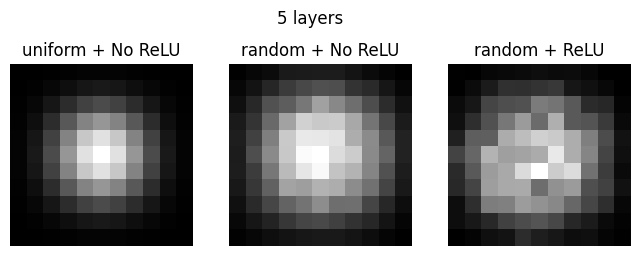

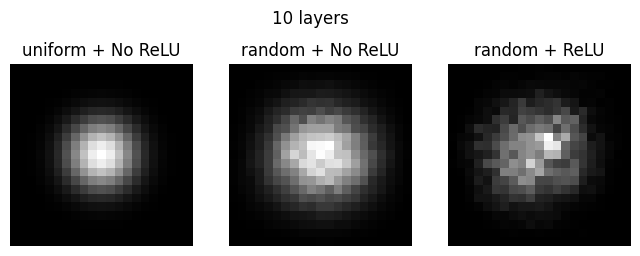

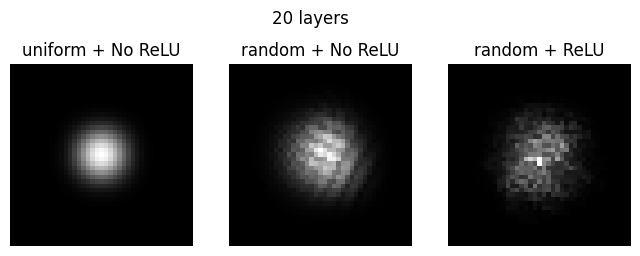

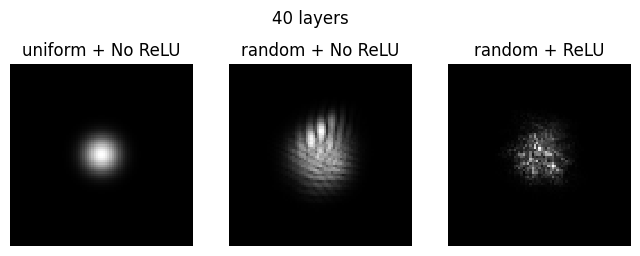

In [4]:
## replicating Figure 1
import matplotlib.pyplot as plt

input_size = (1, 100, 100)
erfs = [calculate_erf(model, init_type, input_size, n_iterations=100) for (model, init_type) in zip(models, init_types)]

for num_conv_layers in [5, 10, 20, 40]:
    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle(f'{num_conv_layers} layers')

    window_size = {5: 11, 10: 21, 20: 41, 40: 81}[num_conv_layers]

    center_index = erfs[0].shape[1] // 2

    for i, (init_type, use_relu) in enumerate(init_combinations):
        erf_index = num_conv_layers_options.index(num_conv_layers) * 3 + i

        erf = erfs[erf_index]

        window = erf[center_index - window_size // 2:center_index + window_size // 2 + 1,
                     center_index - window_size // 2:center_index + window_size // 2 + 1]

        axs[i].imshow(window, cmap='gray', interpolation='nearest')
        axs[i].set_title(f"{init_type} + {'ReLU' if use_relu else 'No ReLU'}")
        axs[i].axis('off')

    plt.show()

In [5]:
## Replicating Figure 3
import torch
import torchvision
from torchvision.models import ResNet18_Weights, ResNet50_Weights
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

def initialize_resnet18(pretrained=True):
    resnet18 = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
    return resnet18

def get_output_after_fourth_conv(model, input_tensor):
    mod = create_feature_extractor(model, return_nodes={'layer3.0.conv1': 'layer3'})
    return mod(input_tensor)['layer3']

In [6]:
class Resnet18Conv4(torch.nn.Module):
    def __init__(self, resnet):
        super(Resnet18Conv4, self).__init__()
        self.resnet = resnet

    def forward(self, x):
        return get_output_after_fourth_conv(self.resnet, x)

resnet_trained = Resnet18Conv4(initialize_resnet18())
resnet_random = Resnet18Conv4(initialize_resnet18(pretrained=False))

models = [resnet_random, resnet_trained]
init_types = ["random", "trained"]

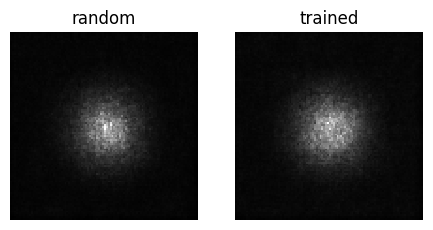

In [7]:
input_size = (3, 100, 100)

erfs = [calculate_erf(model, init_type, input_size, n_iterations=20, is_resnet=True) for model, init_type in zip(models, init_type)]

fig, axs = plt.subplots(1, 2, figsize=(16/3, 3))

for erf_index, init_type in enumerate(init_types):

    window_size = 81

    center_index = erfs[0].shape[1] // 2

    erf = erfs[erf_index]

    #window = erf[:, center_index - window_size // 2:center_index + window_size // 2 + 1,
    #              center_index - window_size // 2:center_index + window_size // 2 + 1]
    window = erf
    window = np.mean(window, axis=0)

    im = axs[erf_index].imshow(window, cmap='gray', interpolation='nearest')
    axs[erf_index].set_title(f"{init_type}")
    axs[erf_index].axis('off')
    plt.title(f'{init_type}')

plt.show()

In [8]:
layers = list(lay_name for lay_name in get_graph_node_names(resnet_trained.resnet)[0] if 'conv' in lay_name)

train_models = []
random_models = []
erfs_18 = []
for layer in layers:
  def get_output_after_conv(model, input_tensor, layer):
    mod = create_feature_extractor(model, return_nodes={layer: 'lay'})
    return mod(input_tensor)['lay']

  class Resnet18Conv(torch.nn.Module):
    def __init__(self, resnet, layer):
        super(Resnet18Conv, self).__init__()
        self.resnet = resnet
        self.layer = layer

    def forward(self, x):
        return get_output_after_conv(self.resnet, x, layer)

  input_size = (3, 200, 200)

  resnet_trained = Resnet18Conv(initialize_resnet18(), layer=layer)
  erf = calculate_erf(resnet_trained, None, input_size, n_iterations=20, is_resnet=True)
  erfs_18.append(erf)

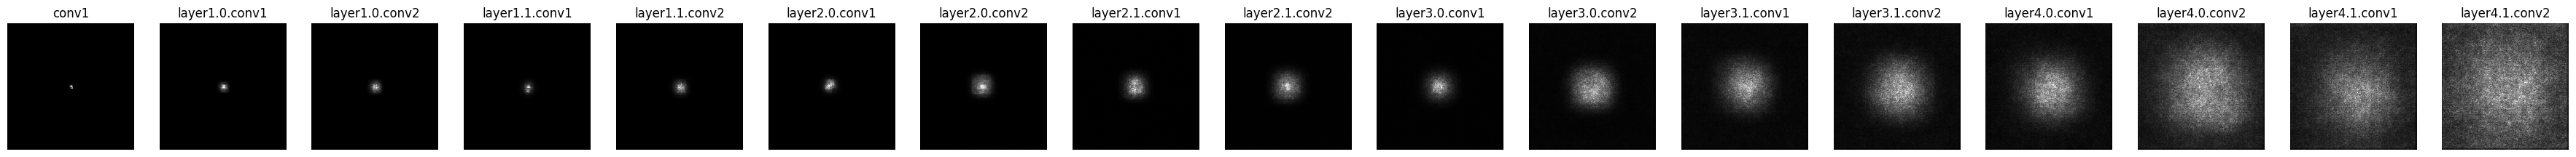

In [9]:
fig, axs = plt.subplots(1, len(erfs_18), figsize=(8/3 * len(erfs_18), 3))

for erf_index, layer in enumerate(layers):
    window_size = 81

    center_index = erfs_18[0].shape[1] // 2

    erf = erfs_18[erf_index]

    #window = erf[:, center_index - window_size // 2:center_index + window_size // 2 + 1,
    #              center_index - window_size // 2:center_index + window_size // 2 + 1]
    window = erf
    window = np.mean(window, axis=0)

    im = axs[erf_index].imshow(window, cmap='gray', interpolation='nearest')
    axs[erf_index].set_title(layer)
    axs[erf_index].axis('off')

plt.show()

In [10]:
# repeat but for resnet50
def initialize_resnet50(pretrained=True):
    resnet50 = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
    return resnet50

rnet = initialize_resnet50()

layers = list(lay_name for lay_name in get_graph_node_names(rnet)[0] if 'conv' in lay_name)

train_models = []
random_models = []
erfs_50 = []
for layer in layers:
  def get_output_after_conv(model, input_tensor, layer):
    mod = create_feature_extractor(model, return_nodes={layer: 'lay'})
    return mod(input_tensor)['lay']

  class Resnet18Conv(torch.nn.Module):
    def __init__(self, resnet, layer):
        super(Resnet18Conv, self).__init__()
        self.resnet = resnet
        self.layer = layer

    def forward(self, x):
        return get_output_after_conv(self.resnet, x, layer)

  input_size = (3, 200, 200)

  resnet_trained = Resnet18Conv(initialize_resnet50(), layer=layer)
  erf = calculate_erf(resnet_trained, None, input_size, n_iterations=20, is_resnet=True)
  erfs_50.append(erf)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


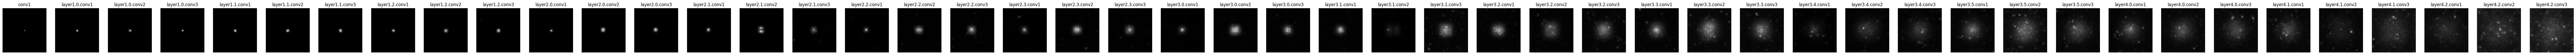

In [11]:
fig, axs = plt.subplots(1, len(erfs_50), figsize=(8/3 * len(erfs_50), 3))

for erf_index, layer in enumerate(layers):
    window_size = 81

    center_index = erfs_50[0].shape[1] // 2

    erf = erfs_50[erf_index]

    window = erf
    window = np.mean(window, axis=0)

    im = axs[erf_index].imshow(window, cmap='gray', interpolation='nearest')
    axs[erf_index].set_title(layer)
    axs[erf_index].axis('off')

plt.show()